# Entrenar el Modelo

In [2]:
#Importar librerias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib #Guardar el Modelo
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
#Cargar DataSet
print("Cargar dataset ya procesado")
df = pd.read_csv('../data/processed/entrenamiento.csv')
df

Cargar dataset ya procesado


,Modo_solicitud,Orden_solicitud,Carrera,Asistencia_diurna_nocturna,Calificacion_previa,Calificacion_madre,Calificacion_padre,Ocupacion_madre,Ocupacion_padre,Desplazado,...,Unidades_1er_sem_aprobadas,Unidades_1er_sem_nota,Unidades_2do_sem_matriculadas,Unidades_2do_sem_evaluaciones,Unidades_2do_sem_aprobadas,Unidades_2do_sem_nota,Tasa_desempleo,Tasa_inflacion,PIB,Es_Desertor
0,8,5,2,1,1,13,10,6,10,1,...,0,0.000000,0,0,0,0.000000,10.8,1.4,1.74,1
1,6,1,11,1,1,1,3,4,4,1,...,6,14.000000,6,6,6,13.666667,13.9,-0.3,0.79,0
2,1,5,5,1,1,22,27,10,10,1,...,0,0.000000,6,0,0,0.000000,10.8,1.4,1.74,1
3,8,2,15,1,1,23,27,6,4,1,...,6,13.428571,6,10,5,12.400000,9.4,-0.8,-3.12,0
4,12,1,3,0,1,22,28,10,10,0,...,5,12.333333,6,6,6,13.000000,13.9,-0.3,0.79,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3625,1,6,15,1,1,1,1,6,5,0,...,5,13.600000,6,8,5,12.666667,15.5,2.8,-4.06,0
3626,1,2,15,1,1,1,1,10,10,1,...,6,12.000000,6,6,2,11.000000,11.1,0.6,2.02,1
3627,1,1,12,1,1,22,27,10,10,1,...,7,14.912500,8,9,1,13.500000,13.9,-0.3,0.79,1
3628,1,1,9,1,1,22,27,8,5,1,...,5,13.800000,5,6,5,12.000000,9.4,-0.8,-3.12,0


In [5]:
#Asignación de variables
objetivo = 'Es_Desertor'

x = df.drop(columns=[objetivo])
y = df[objetivo]

In [6]:
#Division de Datos 80% Entrenamiento y 20% Prueba
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)


In [7]:
#Entrenar el modelo
#Estimación con 100 arboles de decision
modelo = RandomForestClassifier(n_estimators=100, random_state=42)

# El modelo aprende la relación entre x e y
modelo.fit(x_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [16]:
#Guardar el modelo
joblib.dump(modelo, '../model/modelo_a.pkl')


['../model/modelo_a.pkl']

Exactitud del modelo: 0.92



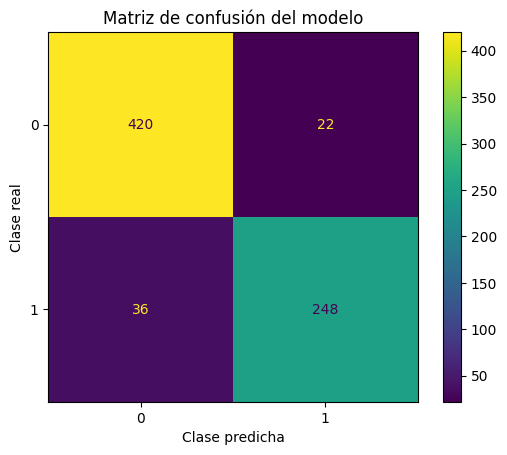

Reporte de Clasificación (en español):
                    Precisión  Sensibilidad  Medida F1    Soporte
Clase 0              0.921053      0.950226   0.935412  442.00000
Clase 1              0.918519      0.873239   0.895307  284.00000
Exactitud            0.920110      0.920110   0.920110    0.92011
Promedio macro       0.919786      0.911733   0.915359  726.00000
Promedio ponderado   0.920061      0.920110   0.919724  726.00000


In [19]:
# Predicciones
y_pred = modelo.predict(x_test)

# Exactitud del modelo
print(f"Exactitud del modelo: {accuracy_score(y_test, y_pred):.2f}\n")

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Matriz de confusión del modelo")
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")
plt.show()

# Reporte de clasificación en español
reporte = classification_report(y_test, y_pred, output_dict=True)
df_reporte = pd.DataFrame(reporte).T

freporte = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(reporte).T

df = df.rename(index={
    "0": "Clase 0",
    "1": "Clase 1",
    "accuracy": "Exactitud",
    "macro avg": "Promedio macro",
    "weighted avg": "Promedio ponderado"
})

df = df.rename(columns={
    "precision": "Precisión",
    "recall": "Sensibilidad",
    "f1-score": "Medida F1",
    "support": "Soporte"
})

print("Reporte de Clasificación (en español):")
print(df)

In [31]:
# Cargar el modelo guardado
modelo_cargado = joblib.load('../model/modelo_a.pkl')

# Nuevo caso para predecir
nuevo_caso = {
    'Modo_solicitud': 1,
    'Orden_solicitud': 1,
    'Carrera': 1,
    'Asistencia_diurna_nocturna': 1,
    'Calificacion_previa': 1,
    'Calificacion_madre': 22,
    'Calificacion_padre': 27,
    'Ocupacion_madre': 10,
    'Ocupacion_padre': 10,
    'Desplazado': 1,
    'Deudor': 0,
    'Pagos_al_dia': 1,
    'Genero': 1,
    'Becado': 0,
    'Edad_al_matricularse': 18,
    'Unidades_1er_sem_matriculadas': 6,
    'Unidades_1er_sem_evaluaciones': 6,
    'Unidades_1er_sem_aprobadas': 6,
    'Unidades_1er_sem_nota': 14.0,
    'Unidades_2do_sem_matriculadas': 6,
    'Unidades_2do_sem_evaluaciones': 6,
    'Unidades_2do_sem_aprobadas': 6,
    'Unidades_2do_sem_nota': 13.5,
    'Tasa_desempleo': 10.8,
    'Tasa_inflacion': 1.4,
    'PIB': 1.74
}

nuevo_caso1 ={
    'Modo_solicitud': 1,
    'Orden_solicitud': 2,
    'Carrera': 1,
    'Asistencia_diurna_nocturna': 0,   # Nocturno
    'Calificacion_previa': 0,          # Bajo rendimiento previo
    'Calificacion_madre': 9,
    'Calificacion_padre': 8,
    'Ocupacion_madre': 4,
    'Ocupacion_padre': 4,
    'Desplazado': 1,                   # Situación vulnerable
    'Deudor': 1,                       # Tiene deudas
    'Pagos_al_dia': 0,                 # Pagos atrasados
    'Genero': 1,
    'Becado': 0,                       # Sin beca
    'Edad_al_matricularse': 24,        # Mayor edad al ingreso
    'Unidades_1er_sem_matriculadas': 6,
    'Unidades_1er_sem_evaluaciones': 4,
    'Unidades_1er_sem_aprobadas': 2,   # Pocas aprobadas
    'Unidades_1er_sem_nota': 8.5,      # Nota baja
    'Unidades_2do_sem_matriculadas': 6,
    'Unidades_2do_sem_evaluaciones': 3,
    'Unidades_2do_sem_aprobadas': 1,   # Muy bajo rendimiento
    'Unidades_2do_sem_nota': 7.8,
    'Tasa_desempleo': 11.5,
    'Tasa_inflacion': 2.1,
    'PIB': 1.10
}

# Convertir a DataFrame
nuevo_df = pd.DataFrame([nuevo_caso1])

# Alinear columnas exactamente como el modelo
nuevo_df = nuevo_df[modelo_cargado.feature_names_in_]

# Predecir
prediccion = modelo_cargado.predict(nuevo_df)

# Resultado
if prediccion[0] == 1:
    print("El estudiante es predicho como Desertor.")
else:
    print("El estudiante es predicho como No Desertor.")


El estudiante es predicho como Desertor.


In [32]:
# Calcular las probabilidades de predicción
probabilidades = modelo_cargado.predict_proba(nuevo_df)

# Mostrar probabilidades en porcentaje
print(f"Probabilidad de NO desertor: {probabilidades[0][0] * 100:.2f}%")
print(f"Probabilidad de SÍ desertor: {probabilidades[0][1] * 100:.2f}%")

# Importancia de las características en la predicción
importancias = modelo_cargado.feature_importances_
nombres_caracteristicas = modelo_cargado.feature_names_in_

df_importancia = pd.DataFrame({
    'Característica': nombres_caracteristicas,
    'Importancia': importancias
})

df_importancia = df_importancia.sort_values(by='Importancia', ascending=False)

print("\nCaracterísticas más importantes que influyen en la predicción:")
print(df_importancia.head(10))


Probabilidad de NO desertor: 2.00%
Probabilidad de SÍ desertor: 98.00%

Características más importantes que influyen en la predicción:
                   Característica  Importancia
21     Unidades_2do_sem_aprobadas     0.200264
17     Unidades_1er_sem_aprobadas     0.137868
22          Unidades_2do_sem_nota     0.137828
18          Unidades_1er_sem_nota     0.091261
11                   Pagos_al_dia     0.062402
14           Edad_al_matricularse     0.033772
20  Unidades_2do_sem_evaluaciones     0.031479
2                         Carrera     0.029422
16  Unidades_1er_sem_evaluaciones     0.026132
19  Unidades_2do_sem_matriculadas     0.022926
